In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import KBinsDiscretizer
from tqdm import tqdm
import numpy as np

In [2]:
def get_aupr(pre, rec):
    pr_value = 0.0
    for ii in range(len(rec[:-1])):
        x_r, x_l = rec[ii], rec[ii+1]
        y_t, y_b = pre[ii], pre[ii+1]
        tempo = abs(x_r - x_l) * (y_t + y_b) * 0.5
        pr_value += tempo
    return pr_value

from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score

def scores_regression(y_true, y_pred):
    # Round predictions to nearest class (0–4)
    y_pred_class = np.clip(np.round(y_pred).astype(int), 0, 4)

    # Core regression metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Accuracy as classification
    acc = accuracy_score(y_true, y_pred_class)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred_class, labels=[0, 1, 2, 3, 4])

    return [mse, rmse, mae, r2, acc], cm

In [3]:
def combine_features(phage_dna, host_dna, phage_pro, host_pro):
    combined = np.concatenate([phage_dna, host_dna, phage_pro, host_pro], axis=1)
    return combined


def load_feature_vector(file_path):
    return np.loadtxt(file_path)


def obtain_features(phage_list, host_list, labels, dna_base, pro_base):
    X_phage_dna, X_host_dna = [], []
    X_phage_pro, X_host_pro = [], []
    for p, h in zip(phage_list, host_list):
        X_phage_dna.append(load_feature_vector(os.path.join(dna_base, 'phage', f'{p}.txt')))
        X_host_dna.append(load_feature_vector(os.path.join(dna_base, 'bacteria', f'{h}.txt')))
        X_phage_pro.append(load_feature_vector(os.path.join(pro_base, 'phage', f'{p}.txt')))
        X_host_pro.append(load_feature_vector(os.path.join(pro_base, 'bacteria', f'{h}.txt')))
    return (np.array(X_phage_dna), np.array(X_host_dna),
            np.array(X_phage_pro), np.array(X_host_pro),
            np.array(labels))


In [4]:
interaction_matrix_path = "./ordinal_dataset_features/ordinal_interaction_matrix.csv"

dna_base = './ordinal_dataset_features/dna_features_ordinal_data'
pro_base = './ordinal_dataset_features/prot_features_ordinal_data'

In [5]:
df = pd.read_csv(interaction_matrix_path, index_col=0, sep=";")

valid_phages = set([f.split('.')[0] for f in os.listdir(dna_base + "/phage") if f.endswith('.txt')])
valid_hosts = set([f.split('.')[0] for f in os.listdir(pro_base + "/bacteria") if f.endswith('.txt')])

#filter unused interaction since matrix to large
df = df.loc[df.index.intersection(valid_hosts), df.columns.intersection(valid_phages)]

phages = df.columns.tolist()
hosts = df.index.tolist()
print(len(phages))
print(len(hosts))
# Prepare data as list of (phage, host, label)

96
402


In [6]:
all_data = []

for p in phages:
    for h in hosts:
        label = df.loc[h, p]
        if pd.isna(label):
            continue  # Skip missing values
        all_data.append([p, h, label])

In [7]:

labels = np.asarray([row[2] for row in all_data])
binner = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
stratify_labels = binner.fit_transform(labels.reshape(-1, 1)).astype(int).ravel()

kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

X_full = []
y_full = []
for row in all_data:
    X_full.append(combine_features(*obtain_features([row[0]], [row[1]], [row[2]], dna_base, pro_base)[:-1]))
    y_full.append(row[2])
X_full = np.vstack(X_full)
y_full = np.array(y_full)

param_grid = {
    'n_estimators': [150, 200],
    'max_depth': [10, 8],
    'learning_rate': [0.15, 0.1],
}

reg_base = XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42)
grid_search = GridSearchCV(reg_base, param_grid, cv=3, n_jobs=7, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_full, y_full)
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Hyperparameters: {'learning_rate': 0.15, 'max_depth': 10, 'n_estimators': 150}


In [8]:

# Cross-validation with tuned model
results_all = []
models = []
conf_matrices = []
pbar = tqdm(total=kf.get_n_splits(all_data, stratify_labels))

for fold, (train_idx, val_idx) in enumerate(kf.split(all_data, stratify_labels)):
    print(f"Fold {fold + 1}")

    train_set = [all_data[i] for i in train_idx]
    val_set = [all_data[i] for i in val_idx]

    train_phages = [x[0] for x in train_set]
    train_hosts = [x[1] for x in train_set]
    train_labels = [x[2] for x in train_set]

    val_phages = [x[0] for x in val_set]
    val_hosts = [x[1] for x in val_set]
    val_labels = [x[2] for x in val_set]

    X_phage_dna_tr, X_host_dna_tr, X_phage_pro_tr, X_host_pro_tr, y_train = obtain_features(
        train_phages, train_hosts, train_labels, dna_base, pro_base)
    X_phage_dna_val, X_host_dna_val, X_phage_pro_val, X_host_pro_val, y_val = obtain_features(
        val_phages, val_hosts, val_labels, dna_base, pro_base)

    X_train_combined = combine_features(X_phage_dna_tr, X_host_dna_tr, X_phage_pro_tr, X_host_pro_tr)
    X_val_combined = combine_features(X_phage_dna_val, X_host_dna_val, X_phage_pro_val, X_host_pro_val)

    best_model = XGBRegressor(**best_params, objective='reg:squarederror', n_jobs=-1, random_state=42)
    best_model.fit(X_train_combined, y_train)
    models.append(best_model)

    y_pred = best_model.predict(X_val_combined)

    try:
         fold_scores, cm = scores_regression(y_val, y_pred) 
    except Exception as e:
        print(f"Error on fold: {e}")
        fold_scores = [np.nan] * 5

    results_all.append(fold_scores)
    conf_matrices.append(cm)
    pbar.update(1)

pbar.close()


  0%|          | 0/5 [00:00<?, ?it/s]

Fold 1


 20%|██        | 1/5 [02:45<11:02, 165.59s/it]

Fold 2


 40%|████      | 2/5 [05:28<08:11, 163.73s/it]

Fold 3


 60%|██████    | 3/5 [08:06<05:22, 161.32s/it]

Fold 4


 80%|████████  | 4/5 [10:45<02:40, 160.52s/it]

Fold 5


100%|██████████| 5/5 [13:16<00:00, 159.24s/it]


In [9]:
metric_names = ["MSE", "RMSE", "MAE", "R2", "ACC"]

results_array = np.array(results_all)
results_df = pd.DataFrame(results_array, columns=metric_names)
results_df.index = [f"Fold {i + 1}" for i in range(len(results_all))]

# Print fold-wise results
print("=== Fold-wise Performance ===")
display(results_df)

# Summary stats
print("\n=== Mean ===")
display(results_df.mean())

print("\n=== Std Dev ===")
display(results_df.std())

=== Fold-wise Performance ===


,MSE,RMSE,MAE,R2,ACC
Fold 1,0.447580,0.669014,0.364974,0.543887,0.765708
Fold 2,0.427971,0.654195,0.358046,0.563870,0.768961
Fold 3,0.426657,0.653190,0.360888,0.565684,0.766749
Fold 4,0.429148,0.655094,0.364151,0.563026,0.761285
Fold 5,0.439088,0.662637,0.367262,0.553281,0.764798



=== Mean ===


MSE     0.434089
RMSE    0.658826
MAE     0.363064
R2      0.557949
ACC     0.765500
dtype: float64


=== Std Dev ===


MSE     0.009001
RMSE    0.006809
MAE     0.003619
R2      0.009222
ACC     0.002821
dtype: float64

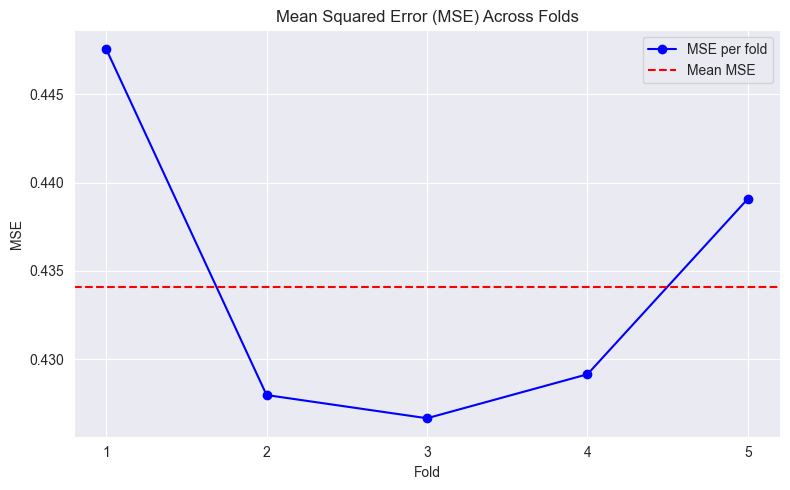

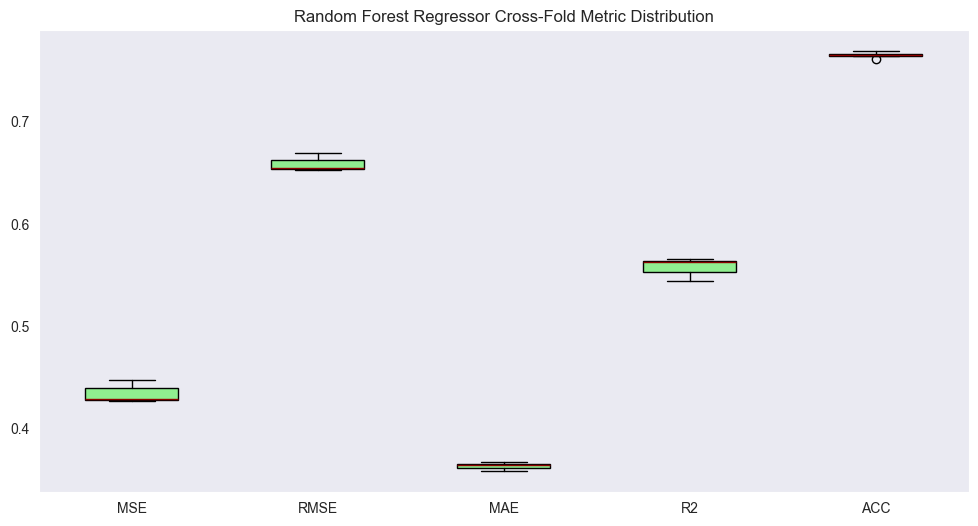

In [10]:
import matplotlib.pyplot as plt

# Assuming results_array[:, 0] contains MSE values per fold
mse_values = results_array[:, 0]

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(mse_values) + 1), mse_values, marker='o', linestyle='-', color='blue', label='MSE per fold')
plt.axhline(np.mean(mse_values), color='red', linestyle='--', label='Mean MSE')
plt.title('Mean Squared Error (MSE) Across Folds')
plt.xlabel('Fold')
plt.ylabel('MSE')
plt.xticks(range(1, len(mse_values) + 1))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 6))
plt.boxplot(results_array, tick_labels=metric_names, patch_artist=True,
            boxprops=dict(facecolor='lightgreen', color='black'),
            medianprops=dict(color='darkred'),
            whiskerprops=dict(color='black'))
plt.title("Random Forest Regressor Cross-Fold Metric Distribution")
plt.grid()
plt.show()

[[26631  3331   460    36     1]
 [ 1033  1518   404    57     2]
 [  386  1005   749   158     8]
 [  113   386   522   314    33]
 [   62   246   365   405   210]]


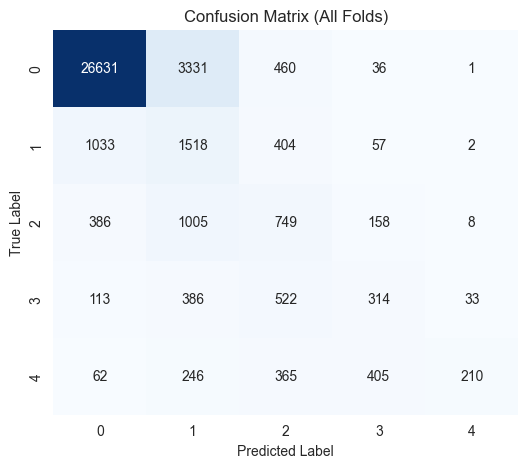

In [11]:

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Sum all confusion matrices
avg_cm = np.sum(conf_matrices, axis=0)
print(avg_cm)

# Step 2: Plot the averaged confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(avg_cm, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (All Folds)")
plt.show()

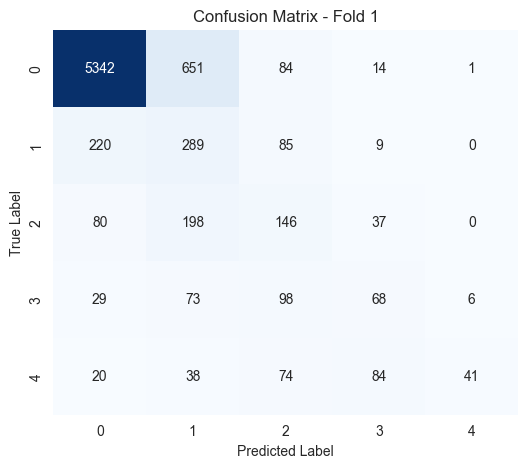

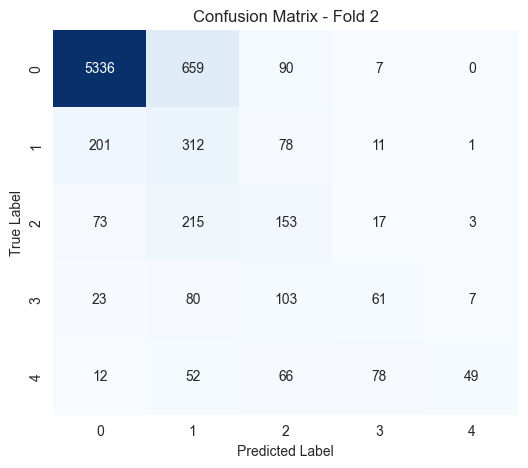

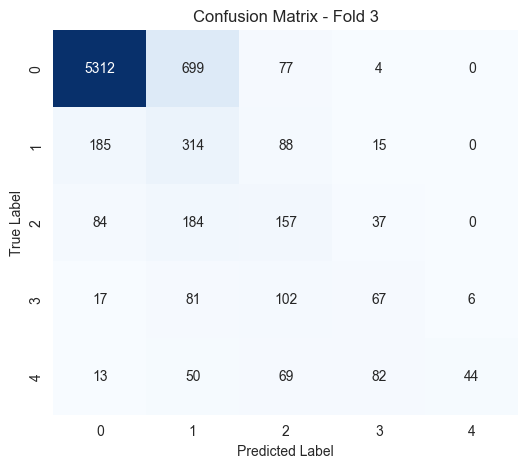

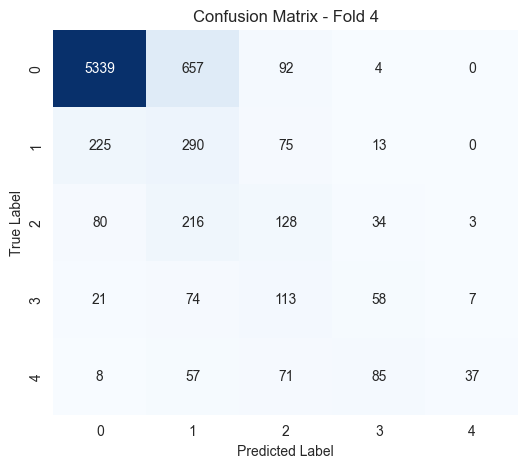

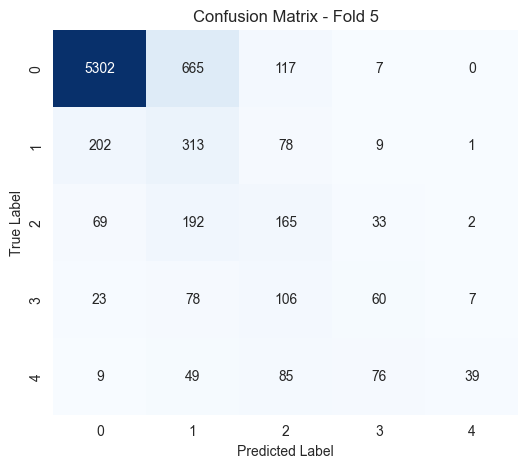

In [12]:

import seaborn as sns
import matplotlib.pyplot as plt

for i, cm in enumerate(conf_matrices):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - Fold {i + 1}")
    plt.show()
    

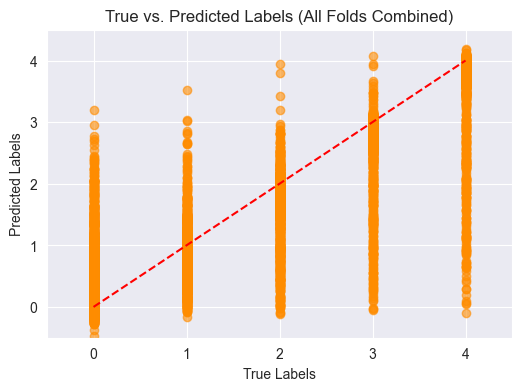

In [13]:
all_y_true = []
all_y_pred = []

for train_idx, test_idx in kf.split(X_full, labels):
    X_test = X_full[test_idx]
    y_test = labels[test_idx]
    y_pred = models[i].predict(X_test)

    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# Convert to NumPy arrays for plotting
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)

# Plotting combined true vs. predicted labels
plt.figure(figsize=(6, 4))
plt.scatter(all_y_true, all_y_pred, alpha=0.6, color='darkorange')
plt.xlabel("True Labels")
plt.ylabel("Predicted Labels")
plt.title("True vs. Predicted Labels (All Folds Combined)")
plt.plot([0, 4], [0, 4], 'r--')  # identity line
plt.xlim(-0.5, 4.5)
plt.ylim(-0.5, 4.5)
plt.grid(True)
plt.show()

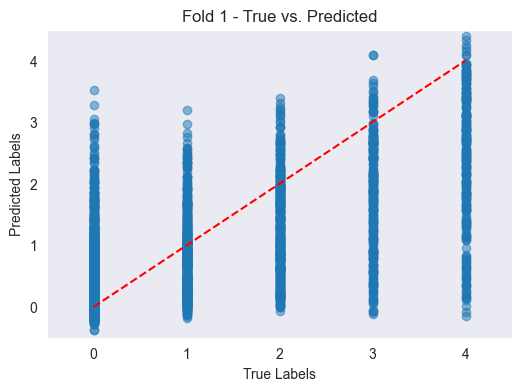

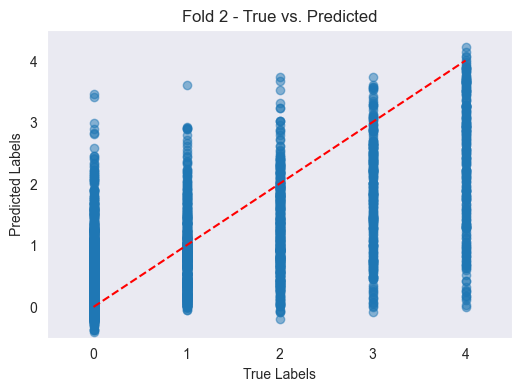

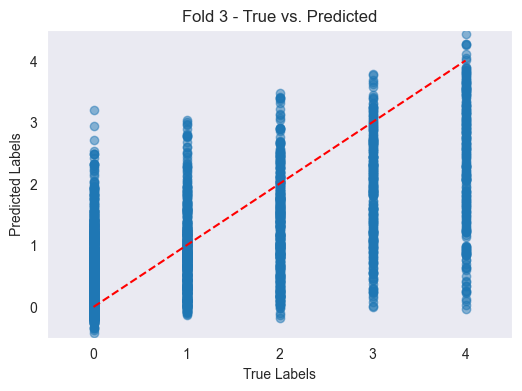

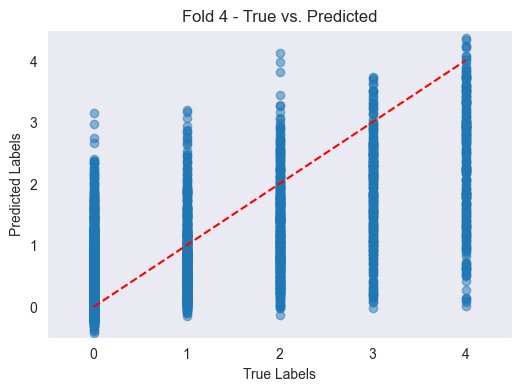

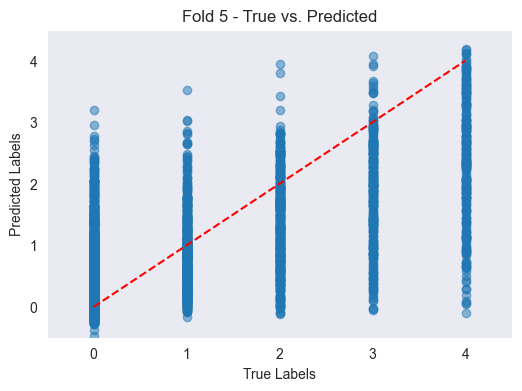

In [14]:
for i, (train_idx, test_idx) in enumerate(kf.split(X_full, labels)):
    X_test = X_full[test_idx]
    y_test = labels[test_idx]
    y_pred = models[i].predict(X_test)

    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("True Labels")
    plt.ylabel("Predicted Labels")
    plt.title(f"Fold {i + 1} - True vs. Predicted")
    plt.grid()
    plt.plot([0, 4], [0, 4], 'r--')
    plt.xlim(-0.5, 4.5)
    plt.ylim(-0.5, 4.5)
    plt.show()


In [15]:
labels = np.asarray([row[2] for row in all_data])

binner = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
stratify_labels = binner.fit_transform(labels.reshape(-1, 1)).astype(int).ravel()

features_full = []
for row in all_data:
    phage, host, label = row
    X_phage_dna, X_host_dna, X_phage_pro, X_host_pro, _ = obtain_features(
        [phage], [host], [label], dna_base, pro_base)
    combined = combine_features(X_phage_dna, X_host_dna, X_phage_pro, X_host_pro)
    features_full.append(combined)

features_full = np.vstack(features_full)

# Hyperparameter tuning
param_grid = {
    'n_estimators': [100,120],
    'max_depth': [10, 15],
    'min_samples_leaf': [5, 10],
}

rf_base = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(
    rf_base,
    param_grid,
    cv=3,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    verbose=1
)
grid_search.fit(features_full, labels)
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Hyperparameters: {'max_depth': 15, 'min_samples_leaf': 5, 'n_estimators': 120}


In [16]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results_all = []
models = []
conf_matrices = []

pbar = tqdm(total=kf.get_n_splits(all_data, stratify_labels))

for fold, (train_idx, val_idx) in enumerate(kf.split(all_data, stratify_labels)):
    print(f"Fold {fold + 1}")

    train_set = [all_data[i] for i in train_idx]
    val_set = [all_data[i] for i in val_idx]

    train_phages = [x[0] for x in train_set]
    train_hosts = [x[1] for x in train_set]
    train_labels = [x[2] for x in train_set]

    val_phages = [x[0] for x in val_set]
    val_hosts = [x[1] for x in val_set]
    val_labels = [x[2] for x in val_set]

    X_phage_dna_tr, X_host_dna_tr, X_phage_pro_tr, X_host_pro_tr, y_train = obtain_features(
        train_phages, train_hosts, train_labels, dna_base, pro_base)
    X_phage_dna_val, X_host_dna_val, X_phage_pro_val, X_host_pro_val, y_val = obtain_features(
        val_phages, val_hosts, val_labels, dna_base, pro_base)

    X_train_combined = combine_features(X_phage_dna_tr, X_host_dna_tr, X_phage_pro_tr, X_host_pro_tr)
    X_val_combined = combine_features(X_phage_dna_val, X_host_dna_val, X_phage_pro_val, X_host_pro_val)

    # Train Random Forest with best params
    model = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
    model.fit(X_train_combined, y_train)
    models.append(model)

    y_pred = model.predict(X_val_combined)

    try:
        fold_scores,cm = scores_regression(y_val, y_pred)  # e.g., [RMSE, MAE, R2]
    except Exception as e:
        print(f"Error in fold {fold+1}: {e}")
        fold_scores = [np.nan] * 5

    print(f"Fold {fold+1} | RMSE: {fold_scores[0]:.4f}, MAE: {fold_scores[1]:.4f}, R2: {fold_scores[2]:.4f}")
    results_all.append(fold_scores)
    conf_matrices.append(cm)
    pbar.update(1)

pbar.close()


  0%|          | 0/5 [00:00<?, ?it/s]

Fold 1


 20%|██        | 1/5 [04:17<17:09, 257.38s/it]

Fold 1 | RMSE: 0.5237, MAE: 0.7237, R2: 0.4146
Fold 2


 40%|████      | 2/5 [08:38<12:59, 259.80s/it]

Fold 2 | RMSE: 0.5149, MAE: 0.7175, R2: 0.4153
Fold 3


 60%|██████    | 3/5 [13:02<08:42, 261.38s/it]

Fold 3 | RMSE: 0.5323, MAE: 0.7296, R2: 0.4221
Fold 4


 80%|████████  | 4/5 [17:26<04:22, 262.51s/it]

Fold 4 | RMSE: 0.5254, MAE: 0.7248, R2: 0.4197
Fold 5


100%|██████████| 5/5 [22:10<00:00, 266.07s/it]

Fold 5 | RMSE: 0.5233, MAE: 0.7234, R2: 0.4242


In [17]:
metric_names = ["MSE", "RMSE", "MAE", "R2", "ACC"]

results_array = np.array(results_all)
results_df = pd.DataFrame(results_array, columns=metric_names)
results_df.index = [f"Fold {i + 1}" for i in range(len(results_all))]

# Print fold-wise results
print("=== Fold-wise Performance ===")
display(results_df)

# Summary stats
print("\n=== Mean ===")
display(results_df.mean())

print("\n=== Std Dev ===")
display(results_df.std())

=== Fold-wise Performance ===


,MSE,RMSE,MAE,R2,ACC
Fold 1,0.523705,0.723675,0.414610,0.466311,0.753480
Fold 2,0.514851,0.717531,0.415350,0.475334,0.754521
Fold 3,0.532283,0.729577,0.422089,0.458162,0.749707
Fold 4,0.525375,0.724827,0.419733,0.465044,0.746585
Fold 5,0.523314,0.723404,0.424170,0.467591,0.741251



=== Mean ===


MSE     0.523906
RMSE    0.723803
MAE     0.419190
R2      0.466488
ACC     0.749109
dtype: float64


=== Std Dev ===


MSE     0.006219
RMSE    0.004298
MAE     0.004160
R2      0.006142
ACC     0.005405
dtype: float64

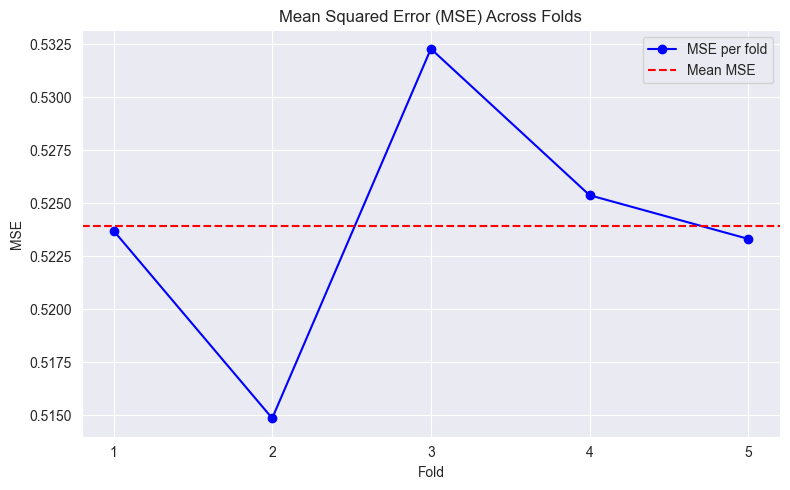

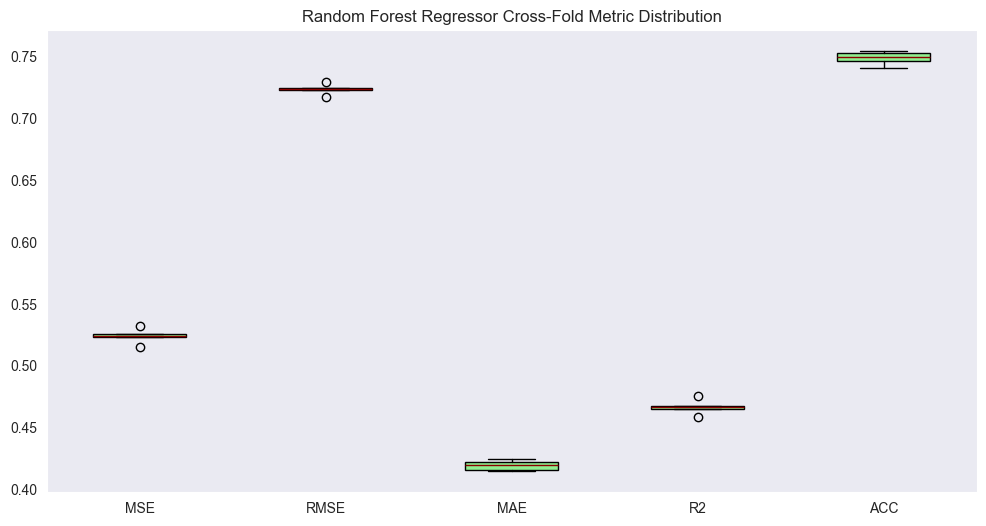

In [18]:

import matplotlib.pyplot as plt

# Assuming results_array[:, 0] contains MSE values per fold
mse_values = results_array[:, 0]

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(mse_values) + 1), mse_values, marker='o', linestyle='-', color='blue', label='MSE per fold')
plt.axhline(np.mean(mse_values), color='red', linestyle='--', label='Mean MSE')
plt.title('Mean Squared Error (MSE) Across Folds')
plt.xlabel('Fold')
plt.ylabel('MSE')
plt.xticks(range(1, len(mse_values) + 1))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 6))
plt.boxplot(results_array, tick_labels=metric_names, patch_artist=True,
            boxprops=dict(facecolor='lightgreen', color='black'),
            medianprops=dict(color='darkred'),
            whiskerprops=dict(color='black'))
plt.title("Random Forest Regressor Cross-Fold Metric Distribution")
plt.grid()
plt.show()

[[26547  3458   445     9     0]
 [ 1216  1431   336    31     0]
 [  554  1077   580    95     0]
 [  174   545   461   183     5]
 [  110   371   402   354    51]]


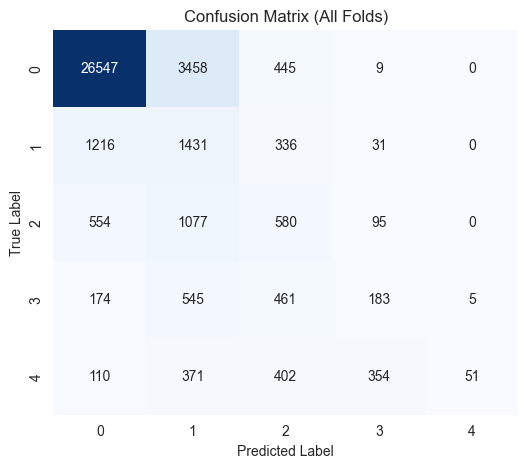

In [19]:

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Sum all confusion matrices
avg_cm = np.sum(conf_matrices, axis=0)
print(avg_cm)

# Step 2: Plot the averaged confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(avg_cm, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (All Folds)")
plt.show()

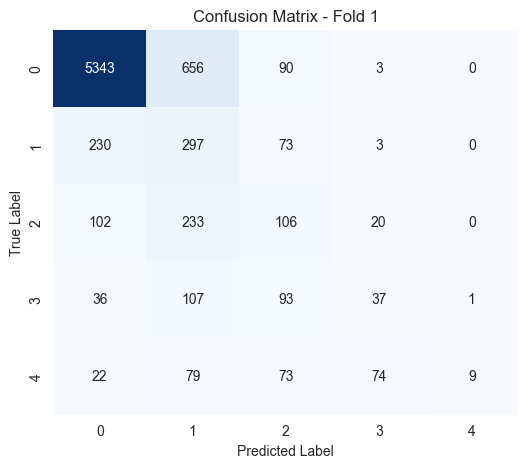

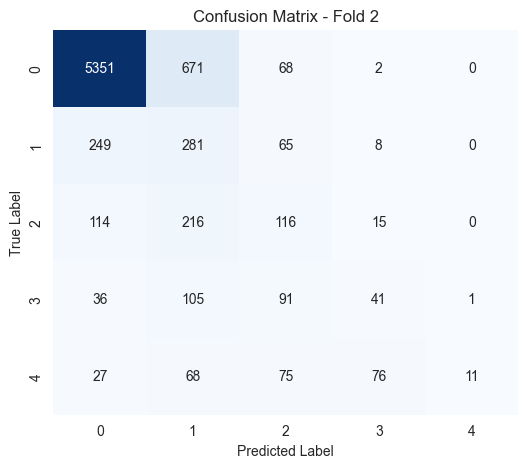

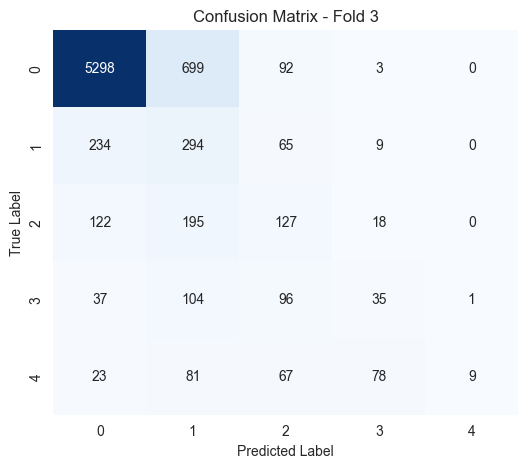

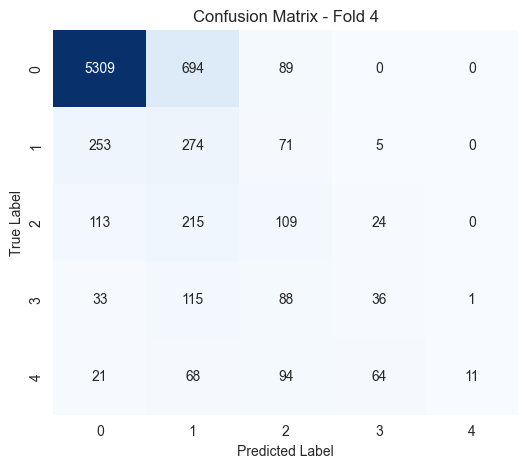

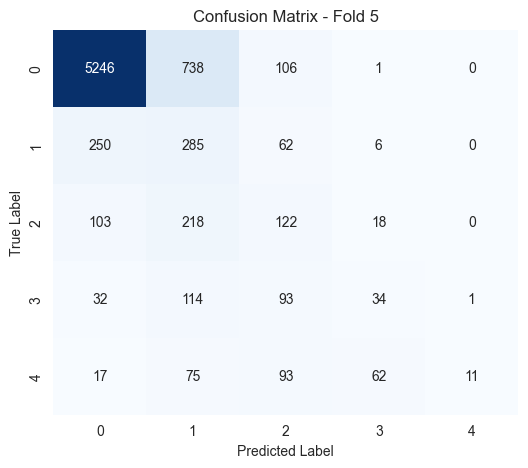

In [20]:

import seaborn as sns
import matplotlib.pyplot as plt

for i, cm in enumerate(conf_matrices):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - Fold {i + 1}")
    plt.show()

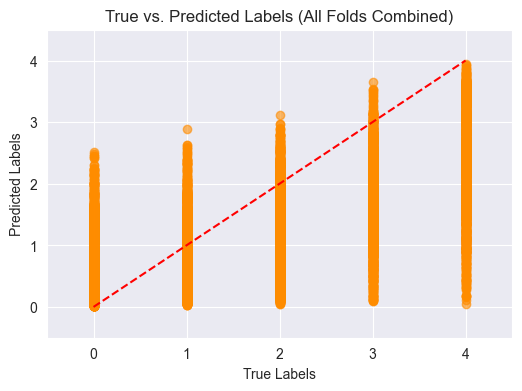

In [21]:

all_y_true = []
all_y_pred = []

for train_idx, test_idx in kf.split(features_full, labels):
    X_test = features_full[test_idx]
    y_test = labels[test_idx]
    y_pred = models[i].predict(X_test)

    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# Convert to NumPy arrays for plotting
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)

# Plotting combined true vs. predicted labels
plt.figure(figsize=(6, 4))
plt.scatter(all_y_true, all_y_pred, alpha=0.6, color='darkorange')
plt.xlabel("True Labels")
plt.ylabel("Predicted Labels")
plt.title("True vs. Predicted Labels (All Folds Combined)")
plt.plot([0, 4], [0, 4], 'r--')  # identity line
plt.xlim(-0.5, 4.5)
plt.ylim(-0.5, 4.5)
plt.grid(True)
plt.show()

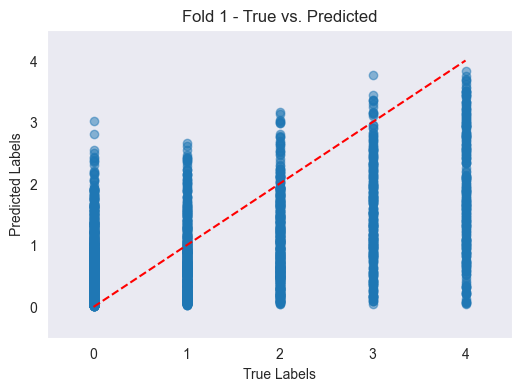

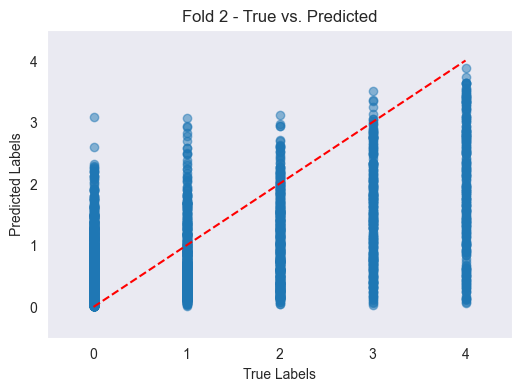

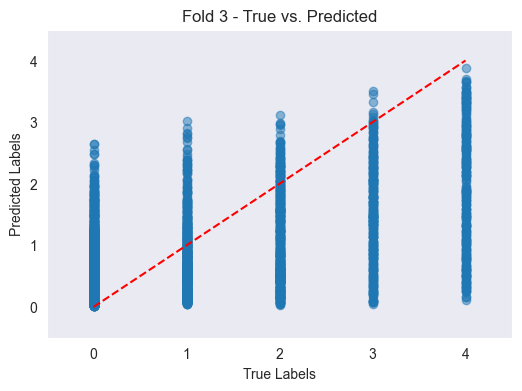

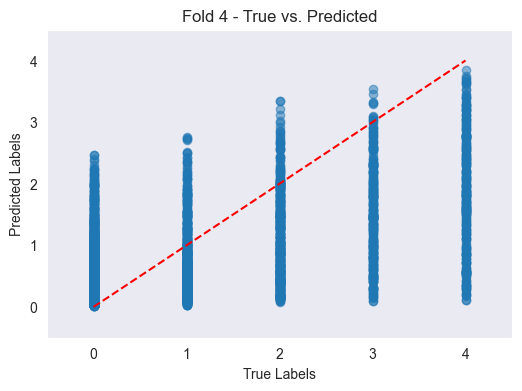

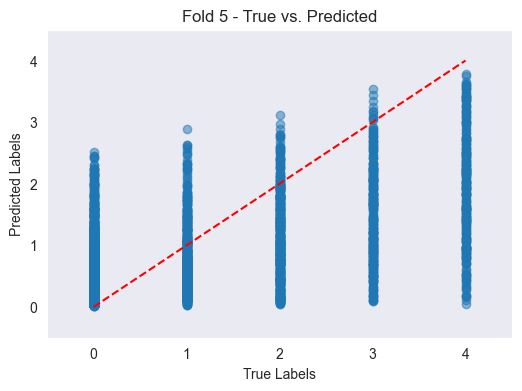

In [22]:

for i, (train_idx, test_idx) in enumerate(kf.split(features_full, labels)):
    X_test = features_full[test_idx]
    y_test = labels[test_idx]
    y_pred = models[i].predict(X_test)

    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("True Labels")
    plt.ylabel("Predicted Labels")
    plt.title(f"Fold {i + 1} - True vs. Predicted")
    plt.grid()
    plt.plot([0, 4], [0, 4], 'r--')
    plt.xlim(-0.5, 4.5)
    plt.ylim(-0.5, 4.5)
    plt.show()


# Baseline

In [23]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression

# Baseline storage
baseline_results = {
    "Dummy": [],
    "Linear": []
}
baseline_conf_matrices = {
    "Dummy": [],
    "Linear": []
}

# Reuse the same StratifiedKFold
pbar_baseline = tqdm(total=kf.get_n_splits(all_data, stratify_labels), desc="Baselines")

for fold, (train_idx, val_idx) in enumerate(kf.split(all_data, stratify_labels)):
    train_set = [all_data[i] for i in train_idx]
    val_set = [all_data[i] for i in val_idx]

    train_phages = [x[0] for x in train_set]
    train_hosts = [x[1] for x in train_set]
    train_labels = [x[2] for x in train_set]

    val_phages = [x[0] for x in val_set]
    val_hosts = [x[1] for x in val_set]
    val_labels = [x[2] for x in val_set]

    X_phage_dna_tr, X_host_dna_tr, X_phage_pro_tr, X_host_pro_tr, y_train = obtain_features(
        train_phages, train_hosts, train_labels, dna_base, pro_base)
    X_phage_dna_val, X_host_dna_val, X_phage_pro_val, X_host_pro_val, y_val = obtain_features(
        val_phages, val_hosts, val_labels, dna_base, pro_base)

    X_train_combined = combine_features(X_phage_dna_tr, X_host_dna_tr, X_phage_pro_tr, X_host_pro_tr)
    X_val_combined = combine_features(X_phage_dna_val, X_host_dna_val, X_phage_pro_val, X_host_pro_val)

    # Dummy Regressor (mean)
    dummy = DummyRegressor(strategy="mean")
    dummy.fit(X_train_combined, y_train)
    y_dummy_pred = dummy.predict(X_val_combined)
    scores_dummy, cm_dummy = scores_regression(y_val, y_dummy_pred)
    baseline_results["Dummy"].append(scores_dummy)
    baseline_conf_matrices["Dummy"].append(cm_dummy)

    # Linear Regression
    linreg = LinearRegression()
    linreg.fit(X_train_combined, y_train)
    y_linreg_pred = linreg.predict(X_val_combined)
    scores_linreg, cm_linreg = scores_regression(y_val, y_linreg_pred)
    baseline_results["Linear"].append(scores_linreg)
    baseline_conf_matrices["Linear"].append(cm_linreg)

    pbar_baseline.update(1)

pbar_baseline.close()


Baselines: 100%|██████████| 5/5 [04:31<00:00, 54.30s/it]


In [24]:
# Summarize baseline performance
for model_name, results in baseline_results.items():
    print(f"\n=== Baseline: {model_name} ===")
    results_array = np.array(results)
    df_baseline = pd.DataFrame(results_array, columns=metric_names)
    df_baseline.index = [f"Fold {i + 1}" for i in range(len(results))]
    display(df_baseline)
    print("Mean:\n", df_baseline.mean())
    print("Std Dev:\n", df_baseline.std())



=== Baseline: Dummy ===


,MSE,RMSE,MAE,R2,ACC
Fold 1,0.981293,0.990602,0.696038,-5.281579e-08,0.792507
Fold 2,0.981293,0.990602,0.696038,-5.281579e-08,0.792507
Fold 3,0.982365,0.991143,0.696260,-9.690270e-09,0.792507
Fold 4,0.982089,0.991004,0.696149,-4.307997e-09,0.792507
Fold 5,0.982917,0.991422,0.696368,-1.818596e-07,0.792377


Mean:
 MSE     9.819913e-01
RMSE    9.909547e-01
MAE     6.961707e-01
R2     -6.029789e-08
ACC     7.924808e-01
dtype: float64
Std Dev:
 MSE     7.039778e-04
RMSE    3.551943e-04
MAE     1.437098e-04
R2      7.173773e-08
ACC     5.817791e-05
dtype: float64

=== Baseline: Linear ===


,MSE,RMSE,MAE,R2,ACC
Fold 1,0.720351,0.848735,0.568066,0.265917,0.626772
Fold 2,0.718848,0.847849,0.566088,0.267448,0.620138
Fold 3,0.727013,0.852651,0.573190,0.259936,0.620918
Fold 4,0.716006,0.846172,0.563046,0.270935,0.628594
Fold 5,0.713796,0.844864,0.565907,0.273798,0.627423


Mean:
 MSE     0.719203
RMSE    0.848054
MAE     0.567259
R2      0.267607
ACC     0.624769
dtype: float64
Std Dev:
 MSE     0.005047
RMSE    0.002973
MAE     0.003767
R2      0.005271
ACC     0.003936
dtype: float64



=== Combined Confusion Matrix: Dummy ===
[[30459     0     0     0     0]
 [ 3014     0     0     0     0]
 [ 2306     0     0     0     0]
 [ 1368     0     0     0     0]
 [ 1288     0     0     0     0]]


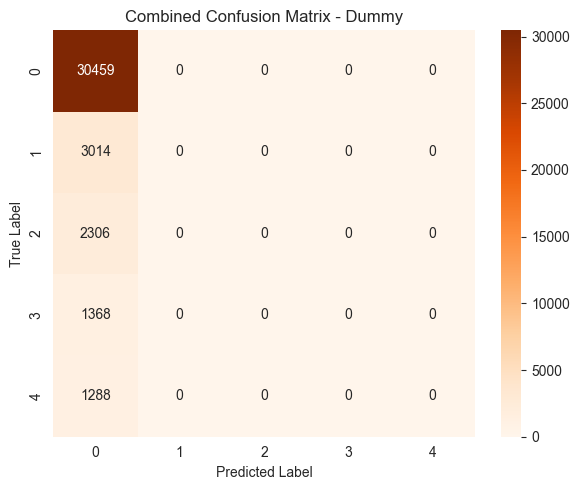


=== Combined Confusion Matrix: Linear ===
[[21709  8482   268     0     0]
 [  751  2045   218     0     0]
 [  369  1677   259     1     0]
 [  192   898   278     0     0]
 [  120   728   436     4     0]]


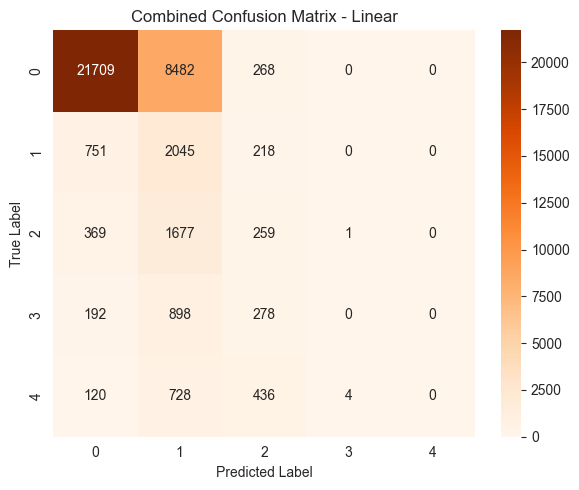

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, title, cmap='Oranges'):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=range(5), yticklabels=range(5))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# ==== Combined Confusion Matrices for Baseline Models ====
for model_name, matrices in baseline_conf_matrices.items():
    if len(matrices) == 0:
        print(f"No confusion matrices found for baseline: {model_name}")
        continue

    # Sum over folds
    total_cm = np.sum(matrices, axis=0)

    print(f"\n=== Combined Confusion Matrix: {model_name} ===")
    print(total_cm)

    # Visualize
    plot_confusion_matrix(total_cm, f"Combined Confusion Matrix - {model_name}")


# Add something like F1 Score or percentage of correct predictions